In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger

In [11]:
# Define variables
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

In [12]:
# Set hyper-parameters
VERBOSITY = 1
EPOCHS = 100
BATCH_SIZE = 512
CLASSES = 10
CHANNELS = 1
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
VALIDATION_RATIO = 0.1

In [18]:
# Load the data (https://www.kaggle.com/c/digit-recognizer/data)

path = "/Users/jeancharles/Desktop/Computer Vision-Qualification goals/Digit-Recognizer-git/Data copy"
    
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

In [23]:
# Reshape data
x = x.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
test = test.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

In [24]:
# One-Hot encoding
y = to_categorical(y, num_classes=CLASSES)

In [25]:
# Prepare training/validation sets
x_training, x_validation, y_training, y_validation = train_test_split(x,
                                                                      y,
                                                                      test_size=VALIDATION_RATIO,
                                                                      shuffle = True)


In [26]:
# Model (0.995)
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(CLASSES, activation="softmax"))

model.compile(optimizer=RMSprop(lr=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

2022-07-01 19:30:30.676628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-01 19:30:30.679538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


/Users/jeancharles/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [27]:
# Data augmentation
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)

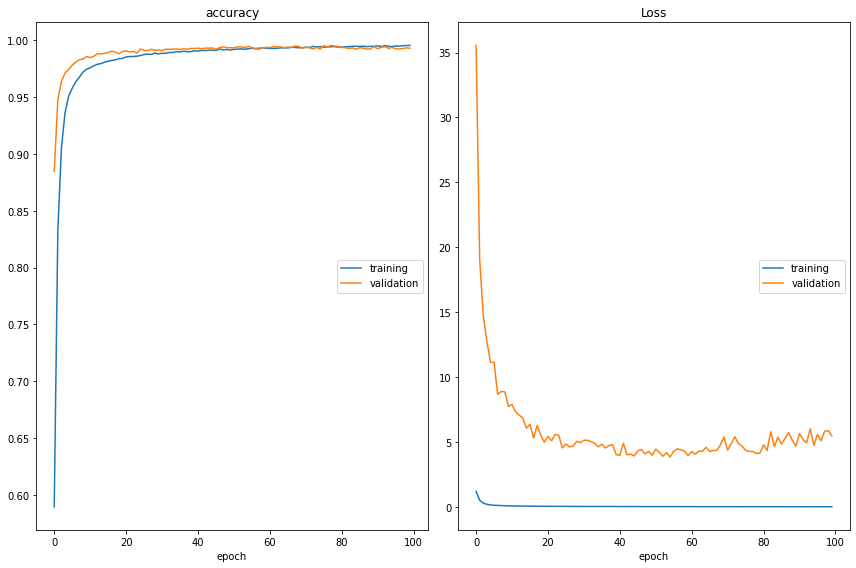

accuracy
	training         	 (min:    0.589, max:    0.995, cur:    0.995)
	validation       	 (min:    0.885, max:    0.995, cur:    0.993)
Loss
	training         	 (min:    0.015, max:    1.198, cur:    0.015)
	validation       	 (min:    3.842, max:   35.547, cur:    5.473)
73/73 [==============================] - 29s 404ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 5.4729 - val_accuracy: 0.9931


In [28]:
# Training
history = model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validation, y_validation),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_training.shape[0] // BATCH_SIZE,
                              callbacks=[PlotLossesKeras(),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=";")])
model.save_weights(MODEL_FILE)

In [33]:
# Testing

predict_x=model.predict(test) 
classes_x=np.argmax(predict_x,axis=1)

pd.DataFrame({"ImageId":list(range(1,len(classes_x)+1)),
              "Label":classes_x}).to_csv(KAGGLE_SUBMISSION_FILE,
                                           index=False,
                                           header=True)

In [40]:
# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.close()